# Large Language Model Classification Project: Support Ticket Categorization

## Problem Statement

### Context

In today's dynamic business landscape, organizations are increasingly recognizing the pivotal role customer feedback plays in shaping the trajectory of their products and services. The ability to swiftly and effectively respond to customer input not only fosters enhanced customer experiences but also serves as a catalyst for growth, prolonged customer engagement, and the nurturing of lifetime value relationships. As a dedicated Product Manager or Product Analyst, staying attuned to the voice of your customers is not just a best practice; it's a strategic imperative.

While your organization may be inundated with a wealth of customer-generated feedback and support tickets, your role entails much more than just processing these inputs. To make your efforts in managing customer experience and expectations truly impactful, you need a structured approach – a method that allows you to discern the most pressing issues, set priorities, and allocate resources judiciously. One of the most effective strategies at your disposal is to harness the power of Support Ticket Categorization.


### Objective

Develop an advanced support ticket categorization system that accurately classifies incoming tickets, assigns relevant tags based on their content, implements mechanisms and generate the first response based on the sentiment for prioritizing tickets for prompt resolution.


## Install additional libraries

In [ ]:
# Install libraries from llama_cpp for GPU runtime
!CMAKE_ARGS='-DLLAMA_CUBLAS=on' FORCE_CMAKE=1 pip install llama-cpp-python==0.1.85 --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 198.7 MB/s eta 0:00:00


In [ ]:
# Install libraries from huggingface, pandas and fastapi
!pip install huggingface_hub==0.20.3 pandas==2.0.3 fastapi==0.110.2 --no-cache-dir -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 26.2 MB/s eta 0:00:00


## Importing necessary libraries

In [ ]:
# Import libraries for data manipulation and utilities
import re
import time
import json
import random
import numpy as np
import pandas as pd

# Import libraries for error handling
import warnings

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries from hugging face hub module
import huggingface_hub as hgh
from huggingface_hub import *

# Import libraries from llama module
import llama_cpp as lma
from llama_cpp import *

In [ ]:
# Apply settings

# Ignore warnings
warnings.filterwarnings('ignore')

# Set limit for the displayed columns in a DataFrame
pd.set_option('display.max_columns', 50)

# Set precision of floating numbers to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Set fixed seed for random number generators
random_state = 1

random.seed(random_state)
np.random.seed(random_state)

## Loading the dataset

In [ ]:
# Read the file
df = pd.read_csv('/content/support_ticket_text_data_mid_term.csv')

## Data Overview

### Checking the summary of the data

In [ ]:
# Display the summary of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   support_tick_id      21 non-null     object
 1   support_ticket_text  21 non-null     object
dtypes: object(2)
memory usage: 464.0+ bytes


**Observations:**
* The dataset contains 21 rows with 2 columns.
* The size of the DataFrame is 464 Bytes.
* There is only 1 data type in the dataset:
  * object (2): support_tick_id, support_ticket_text

### Checking the first 5 rows of the data

In [ ]:
# Display the first 5 rows of the data
df.head(5)

,support_tick_id,support_ticket_text
0,ST2023-006,My internet connection has significantly slowe...
1,ST2023-007,Urgent help required! My laptop refuses to sta...
2,ST2023-008,I've accidentally deleted essential work docum...
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...
4,ST2023-010,"My smartphone battery is draining rapidly, eve..."


**Observations:**
* The support_tick_id contains reference numbers to track the issues logged by the users.
* The support_ticket_text contains issues reported by the users.


### Checking the shape of the data

In [ ]:
# Display the shape of the data
df.shape

(21, 2)

**Observations:**
* The dataset contains only 21 rows with 2 columns.


### Checking the missing values in the data

In [ ]:
# Display how many missing values are present in the dataset
df.isna().sum()

support_tick_id        0
support_ticket_text    0
dtype: int64

**Observations:**
* There are no missing values in the dataset.

### Checking the duplicate values in the data

In [ ]:
# Display how many duplicate records are present in the dataset
df.duplicated().sum()

0

In [ ]:
# Display how many duplicate records are present in the dataset
df['support_tick_id'].duplicated().sum()

0

**Observations:**
* There are no duplicate values in the dataset.

## Model Building

### Function Definition

In [ ]:
# User-defined functions
def extract_json_data(json_str):
  '''
  Description: Function to extract the data from a JSON string
  Parameters:
    json_str: string, required
      The JSON message where data will be extracted and converted to dictionary
  '''
  try:
    # Find the indices of the opening and closing curly braces
    json_start = json_str.find('{')
    json_end = json_str.rfind('}')

    if json_start != -1 and json_end != -1:
      # Extract the JSON object
      json_extract = json_str[json_start:json_end + 1]
      data_dict = json.loads(json_extract)

      return data_dict
    else:
      print(f'Warning: JSON object not found in response: {json_str}')

      return {}
  except json.JSONDecodeError as e:
    print(f'Error parsing JSON: {e}')

    return {}

def generate_llama_response(prompt, ticket_id = None, ticket = None, category = None, tags = None, priority = None, ettr = None, max_tokens = 1024, temperature = 0.01, stop = ['Q:'], echo = False):
  '''
  Description: Function to generate, process, and return the response from the model
  Parameters:
    prompt: string, required
      The prompt message containing the instructions for the model
    ticket_id: string, optional
      The unique ID used to identify the support ticket, default: None
    ticket: string, optional
      The ticket details regarding the issue encountered by the user, default: None
    category: string, optional
      The category used to classify the issue, default: None
    tags: string, optional
      The sub-category used to provide more context about the issue, default: None
    priority: string, optional
      The priority level based on the severity and magnitude of the issue, default: None
    ettr: string, optional
      The estimated time to resolution (ettr) based on the priority level of the issue, default: None
    max_tokens: int, optional
      The maximum number of tokens to generate from the response of the model, default: 1024
    temperature: float, optional
      The creativity of the response generated by the model, default: 0.01
    stop: list, optional
      The list of characters used to stop the response generation, default: ['Q:']
    echo: bool, optional
      The flag to enable or disable echo generation, default: False
  '''
  model_output = llm(
    f'''
    Q: {(prompt if prompt != None else '')}
    {('TICKET_ID: ' + ticket_id if ticket_id != None else '')}
    {('TICKET_DESC: ' + ticket if ticket != None else '')}
    {('CATEGORY: ' + category if category != None else '')}
    {('TAGS: ' + tags if tags != None else '')}
    {('PRIORITY: ' + priority if priority != None else '')}
    {('ETTR: ' + ettr if ettr != None else '')}
    A:
    ''',
    max_tokens = max_tokens,
    temperature = temperature,
    stop = stop,
    echo = echo
  )
  response_text = model_output['choices'][0]['text']

  return response_text

### Loading the Model

In [ ]:
# Download the model from hugging face
model_name_or_path = 'TheBloke/Mistral-7B-Instruct-v0.2-GGUF'
model_basename = 'mistral-7b-instruct-v0.2.Q6_K.gguf'

model_path = hf_hub_download(
  repo_id = model_name_or_path,
  filename = model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [ ]:
# Initialize the model for GPU runtime
llm = Llama(
  # Model path
  model_path = model_path,
  # Context window
  n_ctx = 1024
)

AVX = 1 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | FMA = 1 | NEON = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 1 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | 


**Observations:**
* The large language model mistral-7b-instruct-v0.2.Q6_K.gguf from Mistral AI will be used to categorize the support tickets.
* The model has 7 billion parameters with 5-bit quantization and in GGUF format (GPT-Generated Unified Format).
* The model was downloaded from Hugging Face Hub with a size of 5.94GB and was loaded into LLama C++ Python API using a context size of 1,024.

## Task 1: Ticket Categorization and Returning Structured Output

In [ ]:
# Create a copy of the DataFrame
data_1 = df.copy()

In [ ]:
# Define the prompt for Task 1
prompt_1 = '''
You are an AI tasked with evaluating the ticket.
Give me an output using the following JSON format with no additional fields:
{
  "category": "CATEGORY"
}
Choose one CATEGORY from the list below based on the TICKET_DESC.
If there is no matching CATEGORY, use what you think is most appropriate.
CATEGORY:
- Software Issues
- Hardware/ Computer Issues
- Network/ Connectivity Issues
- Security Issues
- Data Issues
- User Issues
'''

In [ ]:
# Send the request to the model
start = time.time()
data_1['model_response'] = data_1['support_ticket_text'].apply(lambda x: generate_llama_response(prompt = prompt_1, ticket = x, max_tokens = 64))
end = time.time()

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
# Display the time taken to get the response
print('Time Taken:', (end - start))

Time Taken: 137.22922325134277


In [ ]:
# Display the first 5 rows of the response data
data_1['model_response'].to_frame().head(5)

,model_response
0,"\n {\n ""category"": ""Network/ Connectiv..."
1,"\n {\n ""category"": ""Hardware/ Computer..."
2,"\n {\n ""category"": ""Data Issues""\n }"
3,"\n {\n ""category"": ""Network/ Connectiv..."
4,"\n {\n ""category"": ""Hardware/ Computer..."


In [ ]:
# Display the first 10 ticket desciption and the response
for i in range(10):
  print('Support Ticket Text:', data_1.loc[i, 'support_ticket_text'])
  print('Model Response:', data_1.loc[i, 'model_response'], '\n')

Support Ticket Text: My internet connection has significantly slowed down over the past two days, making it challenging to work efficiently from home. Frequent disconnections are causing major disruptions. Please assist in resolving this connectivity issue promptly.
Model Response: 
    {
      "category": "Network/ Connectivity Issues"
    } 

Support Ticket Text: Urgent help required! My laptop refuses to start, and I have a crucial presentation scheduled for tomorrow. I've attempted a restart, but it hasn't worked. Please provide immediate assistance to resolve this hardware issue
Model Response: 
    {
      "category": "Hardware/ Computer Issues"
    } 

Support Ticket Text: I've accidentally deleted essential work documents, causing substantial data loss. I understand the need to avoid further actions on my device. Can you please prioritize the data recovery process and guide me through it?
Model Response: 
    {
      "category": "Data Issues"
    } 

Support Ticket Text: Despit

In [ ]:
# Convert the model response from JSON format to dictionary
data_1['model_response_parsed'] = data_1['model_response'].apply(extract_json_data)
data_1['model_response_parsed'].to_frame().head()

,model_response_parsed
0,{'category': 'Network/ Connectivity Issues'}
1,{'category': 'Hardware/ Computer Issues'}
2,{'category': 'Data Issues'}
3,{'category': 'Network/ Connectivity Issues'}
4,{'category': 'Hardware/ Computer Issues'}


In [ ]:
# Display the counts of each category
data_1['model_response_parsed'].value_counts().to_frame()

,count
model_response_parsed,
{'category': 'Hardware/ Computer Issues'},10
{'category': 'Network/ Connectivity Issues'},5
{'category': 'Data Issues'},4
{'category': 'User Issues'},1
{'category': 'Software Issues'},1


In [ ]:
# Normalize the parsed model response
model_response_parsed_df_1 = pd.json_normalize(data_1['model_response_parsed'])
model_response_parsed_df_1.head()

,category
0,Network/ Connectivity Issues
1,Hardware/ Computer Issues
2,Data Issues
3,Network/ Connectivity Issues
4,Hardware/ Computer Issues


In [ ]:
# Concatinate data and the parsed model response
data_with_parsed_model_output_1 = pd.concat([data_1, model_response_parsed_df_1], axis=1)
data_with_parsed_model_output_1.head()

,support_tick_id,support_ticket_text,model_response,model_response_parsed,category
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""category"": ""Network/ Connectiv...",{'category': 'Network/ Connectivity Issues'},Network/ Connectivity Issues
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n {\n ""category"": ""Hardware/ Computer...",{'category': 'Hardware/ Computer Issues'},Hardware/ Computer Issues
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""category"": ""Data Issues""\n }",{'category': 'Data Issues'},Data Issues
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""category"": ""Network/ Connectiv...",{'category': 'Network/ Connectivity Issues'},Network/ Connectivity Issues
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""category"": ""Hardware/ Computer...",{'category': 'Hardware/ Computer Issues'},Hardware/ Computer Issues


In [ ]:
# Drop model response and the parsed model response columns
final_data_1 = data_with_parsed_model_output_1.drop(['model_response', 'model_response_parsed'], axis = 1)
final_data_1.head()

,support_tick_id,support_ticket_text,category
0,ST2023-006,My internet connection has significantly slowe...,Network/ Connectivity Issues
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware/ Computer Issues
2,ST2023-008,I've accidentally deleted essential work docum...,Data Issues
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Network/ Connectivity Issues
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware/ Computer Issues


**Observations:**
* The model identified the following categories based on the issues described by the users:
  * Hardware/ Computer Issues (with 10 issues)
  * Network/ Connectivity Issues (with 5 issues)
  * Data Issues (with 4 issues)
  * User Issues (with 1 issue)
  * Software Issues (with 1 issue)
* The model was able to follow the JSON format that it was instructed, and it responded with the following fields:
  * category (as string)
* The model took around 2 minutes and 18 seconds to process all 21 issues (around 5.57 seconds per issue) using the following parameters:
  * Max Tokens = 64
  * Temperature = 0.01
  * Stop = ['Q:']
  * Echo = False
  * Support Ticket Text = &lt;Ticket Description&gt;
  * Prompt:
    ```
      You are an AI tasked with evaluating the ticket.
      Give me an output using the following JSON format with no additional fields:
      {
        "category": "CATEGORY"
      }
      Choose one CATEGORY from the list below based on the TICKET_DESC.
      If there is no matching CATEGORY, use what you think is most appropriate.
      CATEGORY:
      - Software Issues
      - Hardware/ Computer Issues
      - Network/ Connectivity Issues
      - Security Issues
      - Data Issues
      - User Issues
    ```



## Task 2: Creating Tags

In [ ]:
# Create a copy of the DataFrame
data_2 = df.copy()

In [ ]:
# Define the prompt for Task 2
prompt_2 = '''
You are an AI tasked with evaluating the ticket.
Give me an output using the following JSON format with no additional fields:
{
  "tags": "TAGS"
}
Choose one or more TAGS from the list below based on the TICKET_DESC and CATEGORY and use a comma to separate the TAGS in one string.
TAGS for Software Issues:
- Operating System Problems
- Application Issues
- Software Installation/ Configuration Problems
- Licensing/ Activation Issues
- Software Compatibility Issues
- Software Corruption
- Software Update Issues
- Performance Issues
TAGS for Hardware Issues:
- Display Issues
- Power Issues
- Storage Issues
- Sound/ Audio Issues
- Hardware Failure
- Printer/ Scanner Issues
- Motherboard/ Chipset Issues
- Optical Drive Issues
- Peripheral Issues
- Hardware Installation/ Configuration Problems
- Hardware Compatibility Issues
- Performance Issues
TAGS for Network/ Connectivity Issues:
- Network Access/ Authentication Issues
- Network/ Internet Outages
- Server Connectivity Issues
- Wi-Fi Connectivity Issues
- Firewall Issues
- VPN (Private Connection) Issues
- DNS (Resolution) Issues
TAGS for Email/ Communication Issues:
- Email Account Setup/ Configuration Problems
- Email Sending/ Receiving Issues
- Calendar/ Meeting Scheduling Problems
- Collaboration/ Instant Messaging Issues
- Video Conferencing Issues
- Communication Platform Issues
TAGS for Security Issues:
- Suspicious Activity/ Potential Security Breaches
- Firewall/ Antivirus Software Issues
- Virus/ Malware Removal
- Spam and Phishing Issues
- Data Breaches
- Encryption/ Decryption Issues
- Compliance/ Regulatory Issues
TAGS for Data Issues:
- Data Backup/ Data Access Problems
- Data Loss/ Data Corruption
- Data Quality Issues
TAGS for User Issues:
- User Authentication Issues
- User Password Reset
- User Account Lockout
- User Account Setup/ Configuration Problems
- User Access/ Permission Issues
- User Training/ Support Needs
- User Error/ Mistake Resolution
TAGS for Other Issues:
- IT Asset Management
- IT Documentation/ Knowledge-base Issues
- IT Policy/ Procedure Questions
- Business Continuity/ Disaster Recovery Issues
- General IT Consulting/ Advisory Services
If there is no matching TAGS, use what you think is most appropriate.
'''

In [ ]:
# Send the request to the model
start = time.time()
data_2['model_response'] = final_data_1[['support_ticket_text', 'category']].apply(lambda x: generate_llama_response(prompt = prompt_2, ticket = x[0], category = x[1], max_tokens = 64), axis = 1)
end = time.time()

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
# Display the time taken to get the response
print('Time Taken:', end - start)

Time Taken: 168.15322041511536


In [ ]:
# Display the first 5 rows of the response data
data_2['model_response'].head(5).to_frame()

,model_response
0,"\n {\n ""tags"": ""Network/ Internet Outa..."
1,"\n {\n ""tags"": ""Hardware Failure, Powe..."
2,"\n {\n ""tags"": ""Data Loss/ Data Corrup..."
3,"\n {\n ""tags"": ""Network/ Internet Outa..."
4,"\n {\n ""tags"": ""Hardware Failure, Perf..."


In [ ]:
# Display the first 10 ticket desciption and the response
for i in range(10):
  print('Support Ticket Text:', data_2.loc[i, 'support_ticket_text'])
  print('Model Response:', data_2.loc[i, 'model_response'], '\n')

Support Ticket Text: My internet connection has significantly slowed down over the past two days, making it challenging to work efficiently from home. Frequent disconnections are causing major disruptions. Please assist in resolving this connectivity issue promptly.
Model Response: 
    {
      "tags": "Network/ Internet Outages, Wi-Fi Connectivity Issues"
    } 

Support Ticket Text: Urgent help required! My laptop refuses to start, and I have a crucial presentation scheduled for tomorrow. I've attempted a restart, but it hasn't worked. Please provide immediate assistance to resolve this hardware issue
Model Response: 
    {
      "tags": "Hardware Failure, Power Issues"
    } 

Support Ticket Text: I've accidentally deleted essential work documents, causing substantial data loss. I understand the need to avoid further actions on my device. Can you please prioritize the data recovery process and guide me through it?
Model Response: 
    {
      "tags": "Data Loss/ Data Corruption"
   

In [ ]:
# Convert the model response from JSON format to dictionary
data_2['model_response_parsed'] = data_2['model_response'].apply(extract_json_data)
data_2['model_response_parsed'].to_frame().head()

,model_response_parsed
0,"{'tags': 'Network/ Internet Outages, Wi-Fi Con..."
1,"{'tags': 'Hardware Failure, Power Issues'}"
2,{'tags': 'Data Loss/ Data Corruption'}
3,"{'tags': 'Network/ Internet Outages, Wi-Fi Con..."
4,"{'tags': 'Hardware Failure, Performance Issues'}"


In [ ]:
# Display the counts of each category
data_2["model_response_parsed"].value_counts().to_frame()

,count
model_response_parsed,
"{'tags': 'Network/ Internet Outages, Wi-Fi Connectivity Issues'}",3
{'tags': 'Data Loss/ Data Corruption'},3
"{'tags': 'Hardware Failure, Display Issues'}",1
"{'tags': 'Hardware Failure, Data Loss, Data Recovery'}",1
"{'tags': 'Network/ Connectivity Issues, Wi-Fi Connectivity Issues'}",1
{'tags': 'Network/ Internet Outages'},1
"{'tags': 'Hardware Failure, Peripheral Issues'}",1
"{'tags': 'Data Loss, Data Corruption'}",1
"{'tags': 'Hardware Failure, Data Loss/ Data Corruption'}",1


In [ ]:
# Normalize the parsed model response
model_response_parsed_df_2 = pd.json_normalize(data_2['model_response_parsed'])
model_response_parsed_df_2.head()

,tags
0,"Network/ Internet Outages, Wi-Fi Connectivity ..."
1,"Hardware Failure, Power Issues"
2,Data Loss/ Data Corruption
3,"Network/ Internet Outages, Wi-Fi Connectivity ..."
4,"Hardware Failure, Performance Issues"


In [ ]:
# Concatinate the data and the parsed model response
data_with_parsed_model_output_2 = pd.concat([data_2, model_response_parsed_df_2], axis=1)
data_with_parsed_model_output_2.head()

,support_tick_id,support_ticket_text,model_response,model_response_parsed,tags
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""tags"": ""Network/ Internet Outa...","{'tags': 'Network/ Internet Outages, Wi-Fi Con...","Network/ Internet Outages, Wi-Fi Connectivity ..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n {\n ""tags"": ""Hardware Failure, Powe...","{'tags': 'Hardware Failure, Power Issues'}","Hardware Failure, Power Issues"
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""tags"": ""Data Loss/ Data Corrup...",{'tags': 'Data Loss/ Data Corruption'},Data Loss/ Data Corruption
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""tags"": ""Network/ Internet Outa...","{'tags': 'Network/ Internet Outages, Wi-Fi Con...","Network/ Internet Outages, Wi-Fi Connectivity ..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""tags"": ""Hardware Failure, Perf...","{'tags': 'Hardware Failure, Performance Issues'}","Hardware Failure, Performance Issues"


In [ ]:
# Drop model response and the parsed model response columns
final_data_2 = data_with_parsed_model_output_2.drop(['model_response', 'model_response_parsed'], axis = 1)
final_data_2.head()

,support_tick_id,support_ticket_text,tags
0,ST2023-006,My internet connection has significantly slowe...,"Network/ Internet Outages, Wi-Fi Connectivity ..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"Hardware Failure, Power Issues"
2,ST2023-008,I've accidentally deleted essential work docum...,Data Loss/ Data Corruption
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"Network/ Internet Outages, Wi-Fi Connectivity ..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","Hardware Failure, Performance Issues"


In [ ]:
# Check the value counts of tags column
final_data_2['tags'].value_counts().to_frame()

,count
tags,
"Network/ Internet Outages, Wi-Fi Connectivity Issues",3
Data Loss/ Data Corruption,3
"Hardware Failure, Display Issues",1
"Hardware Failure, Data Loss, Data Recovery",1
"Network/ Connectivity Issues, Wi-Fi Connectivity Issues",1
Network/ Internet Outages,1
"Hardware Failure, Peripheral Issues",1
"Data Loss, Data Corruption",1
"Hardware Failure, Data Loss/ Data Corruption",1


In [ ]:
# Concatinate data and the parsed model response
final_data_2 = pd.concat([final_data_2, final_data_1['category']], axis = 1)

In [ ]:
# Extract only the support ticket ID/ text, category and tags
final_data_2 = final_data_2[['support_tick_id', 'support_ticket_text', 'category', 'tags']]
final_data_2

,support_tick_id,support_ticket_text,category,tags
0,ST2023-006,My internet connection has significantly slowe...,Network/ Connectivity Issues,"Network/ Internet Outages, Wi-Fi Connectivity ..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware/ Computer Issues,"Hardware Failure, Power Issues"
2,ST2023-008,I've accidentally deleted essential work docum...,Data Issues,Data Loss/ Data Corruption
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Network/ Connectivity Issues,"Network/ Internet Outages, Wi-Fi Connectivity ..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware/ Computer Issues,"Hardware Failure, Performance Issues"
5,ST2023-011,I'm locked out of my online banking account an...,User Issues,"User Authentication Issues, User Password Reset"
6,ST2023-012,"My computer's performance is sluggish, severel...",Hardware/ Computer Issues,Performance Issues
7,ST2023-013,I'm experiencing a recurring blue screen error...,Hardware/ Computer Issues,"Hardware Failure, Hardware Installation/ confi..."
8,ST2023-014,My external hard drive isn't being recognized ...,Hardware/ Computer Issues,"Hardware Installation/ Configuration Problems,..."
9,ST2023-015,The graphics card in my gaming laptop seems to...,Hardware/ Computer Issues,"Hardware Failure, Graphics Card Issues, Perfor..."


**Observations:**
* The model identified the following tags based on the categories and issues described by the users:
  * Network/ Internet Outages, Wi-Fi Connectivity Issues (with 3 issues)
  * Data Loss/ Data Corruption (with 3 issues)
  * Hardware Failure, Display Issues (with 1 issue)
  * Hardware Failure, Data Loss, Data Recovery (with 1 issue)
  * Network/ Connectivity Issues, Wi-Fi Connectivity Issues (with 1 issue)
  * Network/ Internet Outages (with 1 issue)
  * Hardware Failure, Peripheral Issues (with 1 issue)
  * Data Loss, Data Corruption (with 1 issue)
  * Hardware Failure, Data Loss/ Data Corruption (with 1 issue)
  * Hardware Failure, Graphics Card Issues, Performance Issues (with 1 issue)
  * Hardware Failure, Power Issues (with 1 issue)
  * Hardware Installation/ Configuration Problems, Storage Issues (with 1 issue)
  * Hardware Failure, Hardware Installation/ Configuration Problems, Performance Issues (with 1 issue)
  * Performance Issues (with 1 issue)
  * User Authentication Issues, User Password Reset (with 1 issue)
  * Hardware Failure, Performance Issues (with 1 issue)
  * Software Installation/ Configuration Problems, Software Compatibility Issues, Performance Issues, Data Loss/ Data Corruption (with 1 issue)
* The model was able to follow the JSON format that it was instructed, and it responded with the following fields:
  * tags (as string)
* The model took around 2 minutes and 49 seconds to process all 21 issues (around 8.05 seconds per issue) using the following parameters:
  * Max Tokens = 64
  * Temperature = 0.01
  * Stop = ['Q:']
  * Echo = False
  * Support Ticket Text = &lt;Ticket Description&gt;
  * Category = &lt;Category&gt;
  * Prompt:
    ```
    You are an AI tasked with evaluating the ticket.
    Give me an output using the following JSON format with no additional fields:
    {
      "tags": "TAGS"
    }
    Choose one or more TAGS from the list below based on the TICKET_DESC and CATEGORY and use a comma to separate the TAGS in one string.
    TAGS for Software Issues:
    - Operating System Problems
    - Application Issues
    - Software Installation/ Configuration Problems
    - Licensing/ Activation Issues
    - Software Compatibility Issues
    - Software Corruption
    - Software Update Issues
    - Performance Issues
    TAGS for Hardware Issues:
    - Display Issues
    - Power Issues
    - Storage Issues
    - Sound/ Audio Issues
    - Hardware Failure
    - Printer/ Scanner Issues
    - Motherboard/ Chipset Issues
    - Optical Drive Issues
    - Peripheral Issues
    - Hardware Installation/ Configuration Problems
    - Hardware Compatibility Issues
    - Performance Issues
    TAGS for Network/ Connectivity Issues:
    - Network Access/ Authentication Issues
    - Network/ Internet Outages
    - Server Connectivity Issues
    - Wi-Fi Connectivity Issues
    - Firewall Issues
    - VPN (Private Connection) Issues
    - DNS (Resolution) Issues
    TAGS for Email/ Communication Issues:
    - Email Account Setup/ Configuration Problems
    - Email Sending/ Receiving Issues
    - Calendar/ Meeting Scheduling Problems
    - Collaboration/ Instant Messaging Issues
    - Video Conferencing Issues
    - Communication Platform Issues
    TAGS for Security Issues:
    - Suspicious Activity/ Potential Security Breaches
    - Firewall/ Antivirus Software Issues
    - Virus/ Malware Removal
    - Spam and Phishing Issues
    - Data Breaches
    - Encryption/ Decryption Issues
    - Compliance/ Regulatory Issues
    TAGS for Data Issues:
    - Data Backup/ Data Access Problems
    - Data Loss/ Data Corruption
    - Data Quality Issues
    TAGS for User Issues:
    - User Authentication Issues
    - User Password Reset
    - User Account Lockout
    - User Account Setup/ Configuration Problems
    - User Access/ Permission Issues
    - User Training/ Support Needs
    - User Error/ Mistake Resolution
    TAGS for Other Issues:
    - IT Asset Management
    - IT Documentation/ Knowledge-base Issues
    - IT Policy/ Procedure Questions
    - Business Continuity/ Disaster Recovery Issues
    - General IT Consulting/ Advisory Services
    If there is no matching TAGS, use what you think is most appropriate.
    ```

## Task 3: Assigning Priority and ETTR

**Note:** To align with the objective (i.e. suggest estimated resolution time), the name **ETTR** (Estimated Time To Resolution) was used instead of **ETA** (Estimated Time of Arrival).

In [ ]:
# Create a copy of the DataFrame
data_3 = df.copy()

In [ ]:
# Define the prompt for Task 3
prompt_3 = '''
You are an AI tasked with evaluating the ticket.
Give me an output using the following JSON format with no additional fields:
{
  "priority": "PRIORITY",
  "ettr": "ETTR"
}
If the severity is high critical, set PRIORITY to "Critical" and set ETTR to "ASAP".
If the severity is medium critical, set PRIORITY to "High" and set ETTR to "2 Days".
If the severity is low critical, set PRIORITY to "Medium" and set ETTR to "4 Days".
If the severity is not critical, set PRIORITY to "Low" and set ETTR to "6 Days".
'''

In [ ]:
# Send the request to the model
start = time.time()
data_3['model_response'] = final_data_2[['support_ticket_text', 'category', 'tags']].apply(lambda x: generate_llama_response(prompt = prompt_3, ticket = x[0], category = x[1], tags = x[2], max_tokens = 512, temperature = 0.01), axis = 1)
end = time.time()

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
# Display the time taken to get the response
print('Time Taken:', (end - start))

Time Taken: 169.54625248908997


In [ ]:
# Display the first 5 rows of the response data
data_3['model_response'].to_frame().head(5)

,model_response
0,"\n {\n ""priority"": ""High"",\n ""ett..."
1,"\n {\n ""priority"": ""Critical"",\n ..."
2,"\n {\n ""priority"": ""Critical"",\n ..."
3,"\n {\n ""priority"": ""Medium"",\n ""e..."
4,"\n {\n ""priority"": ""Medium"",\n ""e..."


In [ ]:
# Display the first 10 ticket desciption and the response
for i in range(10):
  print('Support Ticket Text:', data_3.loc[i, 'support_ticket_text'])
  print('Model Response:', data_3.loc[i, 'model_response'], '\n')

Support Ticket Text: My internet connection has significantly slowed down over the past two days, making it challenging to work efficiently from home. Frequent disconnections are causing major disruptions. Please assist in resolving this connectivity issue promptly.
Model Response: 
    {
      "priority": "High",
      "ettr": "2 Days"
    } 

Support Ticket Text: Urgent help required! My laptop refuses to start, and I have a crucial presentation scheduled for tomorrow. I've attempted a restart, but it hasn't worked. Please provide immediate assistance to resolve this hardware issue
Model Response: 
    {
      "priority": "Critical",
      "ettr": "ASAP"
    } 

Support Ticket Text: I've accidentally deleted essential work documents, causing substantial data loss. I understand the need to avoid further actions on my device. Can you please prioritize the data recovery process and guide me through it?
Model Response: 
    {
      "priority": "Critical",
      "ettr": "ASAP"
    } 

Sup

In [ ]:
# Convert the model response from JSON format to dictionary
data_3['model_response_parsed'] = data_3['model_response'].apply(extract_json_data)
data_3['model_response_parsed'].to_frame().head()

,model_response_parsed
0,"{'priority': 'High', 'ettr': '2 Days'}"
1,"{'priority': 'Critical', 'ettr': 'ASAP'}"
2,"{'priority': 'Critical', 'ettr': 'ASAP'}"
3,"{'priority': 'Medium', 'ettr': '4 Days'}"
4,"{'priority': 'Medium', 'ettr': '4 Days'}"


In [ ]:
# Display the counts of each category
data_3['model_response_parsed'].value_counts().to_frame()

,count
model_response_parsed,
"{'priority': 'Critical', 'ettr': 'ASAP'}",13
"{'priority': 'High', 'ettr': '2 Days'}",4
"{'priority': 'Medium', 'ettr': '4 Days'}",4


In [ ]:
# Normalize the parsed model response
model_response_parsed_df_3 = pd.json_normalize(data_3['model_response_parsed'])
model_response_parsed_df_3.head(21)

,priority,ettr
0,High,2 Days
1,Critical,ASAP
2,Critical,ASAP
3,Medium,4 Days
4,Medium,4 Days
5,Critical,ASAP
6,Critical,ASAP
7,Critical,ASAP
8,High,2 Days
9,High,2 Days


In [ ]:
# Concatinate data and the parsed model response
data_with_parsed_model_output_3 = pd.concat([data_3, model_response_parsed_df_3], axis = 1)
data_with_parsed_model_output_3.head()

,support_tick_id,support_ticket_text,model_response,model_response_parsed,priority,ettr
0,ST2023-006,My internet connection has significantly slowe...,"\n {\n ""priority"": ""High"",\n ""ett...","{'priority': 'High', 'ettr': '2 Days'}",High,2 Days
1,ST2023-007,Urgent help required! My laptop refuses to sta...,"\n {\n ""priority"": ""Critical"",\n ...","{'priority': 'Critical', 'ettr': 'ASAP'}",Critical,ASAP
2,ST2023-008,I've accidentally deleted essential work docum...,"\n {\n ""priority"": ""Critical"",\n ...","{'priority': 'Critical', 'ettr': 'ASAP'}",Critical,ASAP
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,"\n {\n ""priority"": ""Medium"",\n ""e...","{'priority': 'Medium', 'ettr': '4 Days'}",Medium,4 Days
4,ST2023-010,"My smartphone battery is draining rapidly, eve...","\n {\n ""priority"": ""Medium"",\n ""e...","{'priority': 'Medium', 'ettr': '4 Days'}",Medium,4 Days


In [ ]:
# Drop model response and the parsed model response columns
final_data_3 = data_with_parsed_model_output_3.drop(['model_response', 'model_response_parsed'], axis = 1)
final_data_3.head()

,support_tick_id,support_ticket_text,priority,ettr
0,ST2023-006,My internet connection has significantly slowe...,High,2 Days
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Critical,ASAP
2,ST2023-008,I've accidentally deleted essential work docum...,Critical,ASAP
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Medium,4 Days
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Medium,4 Days


In [ ]:
# Check the value counts of priority column
final_data_3['priority'].value_counts().to_frame()

,count
priority,
Critical,13
High,4
Medium,4


In [ ]:
# Check the value counts of ettr column
final_data_3['ettr'].value_counts().to_frame()

,count
ettr,
ASAP,13
2 Days,4
4 Days,4


In [ ]:
# Concatinate data and the parsed model response
final_data_3 = pd.concat([final_data_3, final_data_2[['category', 'tags']]], axis = 1)

In [ ]:
# Extract only the support ticket ID/ text, category, tags, priority and ettr
final_data_3 = final_data_3[['support_tick_id', 'support_ticket_text', 'category', 'tags', 'priority', 'ettr']]
final_data_3

,support_tick_id,support_ticket_text,category,tags,priority,ettr
0,ST2023-006,My internet connection has significantly slowe...,Network/ Connectivity Issues,"Network/ Internet Outages, Wi-Fi Connectivity ...",High,2 Days
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware/ Computer Issues,"Hardware Failure, Power Issues",Critical,ASAP
2,ST2023-008,I've accidentally deleted essential work docum...,Data Issues,Data Loss/ Data Corruption,Critical,ASAP
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Network/ Connectivity Issues,"Network/ Internet Outages, Wi-Fi Connectivity ...",Medium,4 Days
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware/ Computer Issues,"Hardware Failure, Performance Issues",Medium,4 Days
5,ST2023-011,I'm locked out of my online banking account an...,User Issues,"User Authentication Issues, User Password Reset",Critical,ASAP
6,ST2023-012,"My computer's performance is sluggish, severel...",Hardware/ Computer Issues,Performance Issues,Critical,ASAP
7,ST2023-013,I'm experiencing a recurring blue screen error...,Hardware/ Computer Issues,"Hardware Failure, Hardware Installation/ confi...",Critical,ASAP
8,ST2023-014,My external hard drive isn't being recognized ...,Hardware/ Computer Issues,"Hardware Installation/ Configuration Problems,...",High,2 Days
9,ST2023-015,The graphics card in my gaming laptop seems to...,Hardware/ Computer Issues,"Hardware Failure, Graphics Card Issues, Perfor...",High,2 Days


**Observations:**
* The model identified the following priorities and estimated time to resolution (ETTR) based on the categories, tags, and issues described by the users:
  * Critical/ ASAP (with 13 issues)
  * High/ 2 Days (with 4 issues)
  * Medium/ 4 Days (with 4 issues)
* The model was able to follow the JSON format that it was instructed, and it responded with the following fields:
  * priority (as string)
  * ettr (as string)
* The model took around 2 minutes and 50 seconds to process all 21 issues (around 8.10 seconds per issue) using the following parameters:
  * Max Tokens = 512
  * Temperature = 0.01
  * Stop = ['Q:']
  * Echo = False
  * Support Ticket Text = &lt;Ticket Description&gt;
  * Category = &lt;Category&gt;
  * Tags = &lt;Tags&gt;
  * Prompt:
    ```
    You are an AI tasked with evaluating the ticket.
    Give me an output using the following JSON format with no additional fields:
    {
      "priority": "PRIORITY",
      "ettr": "ETTR"
    }
    If the severity is high critical, set PRIORITY to "Critical" and set ETTR to "ASAP".
    If the severity is medium critical, set PRIORITY to "High" and set ETTR to "2 Days".
    If the severity is low critical, set PRIORITY to "Medium" and set ETTR to "4 Days".
    If the severity is not critical, set PRIORITY to "Low" and set ETTR to "6 Days".
    ```

## Task 4: Creating a Draft Response

In [ ]:
# Create a copy of the DataFrame
data_4 = df.copy()

In [ ]:
# Define the prompt for Task 4
prompt_4 = '''
You are a Support Specialist tasked with creating a draft response to users.
You need to populate the fields TICKET_ID, TICKET_DESC, CATEGORY, TAGS, PRIORITY and ETTR with the values that you have received.
The output should be in a plain text format using the exact template below with no additional fields:

Dear User,

Thank you for reaching out to us. Below is the summary of your ticket:
Ticket ID: TICKET_ID
Ticket Description: TICKET_DESC
Category: CATEGORY
Tags: TAGS
Priority: PRIORITY
Estimated Time To Resolution: ETTR

In the meantime, you may try the following troubleshooting steps:
1. Step 1
2. Step 2
3. Step 3

Please let us know if you have further questions. We will keep you updated as we make progress toward our investigation to resolve this issue.

Regards,
Support Team
'''

In [ ]:
# Send the request to the model
start = time.time()
data_4['model_response'] = final_data_3[['support_tick_id', 'support_ticket_text', 'category', 'tags', 'priority', 'ettr']].apply(lambda x: generate_llama_response(prompt = prompt_4, ticket_id = x[0], ticket = x[1], category = x[2], tags = x[3], priority = x[4], ettr = x[5], max_tokens = 1024), axis = 1)
end = time.time()

Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit
Llama.generate: prefix-match hit


In [ ]:
# Display the time taken to get the response
print('Time Taken:', (end - start))

Time Taken: 1335.978615283966


In [ ]:
# Display the first 5 rows of the response data
data_4['model_response'].to_frame().head(5)

,model_response
0,"\nDear User,\n\nThank you for reaching out to ..."
1,"\nDear User,\n\nThank you for reaching out to ..."
2,"\nDear User,\n\nThank you for reaching out to ..."
3,"\nDear User,\n\nThank you for reaching out to ..."
4,"\nDear User,\n\nThank you for reaching out to ..."


In [ ]:
# Display the first 10 ticket desciption and the response
for i in range(10):
  print('Support Ticket Text:', data_4.loc[i, 'support_ticket_text'])
  print('Model Response:', data_4.loc[i, 'model_response'], '\n')

Support Ticket Text: My internet connection has significantly slowed down over the past two days, making it challenging to work efficiently from home. Frequent disconnections are causing major disruptions. Please assist in resolving this connectivity issue promptly.
Model Response: 
Dear User,

Thank you for reaching out to us. Below is the summary of your ticket:
Ticket ID: ST2023-006
Ticket Description: My internet connection has significantly slowed down over the past two days, making it challenging to work efficiently from home. Frequent disconnections are causing major disruptions. Please assist in resolving this connectivity issue promptly.
Category: Network/ Connectivity Issues
Tags: Network/ Internet Outages, Wi-Fi Connectivity Issues
Priority: High
Estimated Time To Resolution: 2 Days

In the meantime, you may try the following troubleshooting steps:
1. Restart your modem and router by unplugging them from the power source for at least 30 seconds before plugging them back in.


In [ ]:
# Concatinate data and the parsed model response
final_data_4 = pd.concat([final_data_3, data_4['model_response']], axis = 1)

In [ ]:
# Rename the final response
final_data_4.rename(columns = {'model_response': 'response'}, inplace = True)

In [ ]:
# Display the final data
final_data_4

,support_tick_id,support_ticket_text,category,tags,priority,ettr,response
0,ST2023-006,My internet connection has significantly slowe...,Network/ Connectivity Issues,"Network/ Internet Outages, Wi-Fi Connectivity ...",High,2 Days,"\nDear User,\n\nThank you for reaching out to ..."
1,ST2023-007,Urgent help required! My laptop refuses to sta...,Hardware/ Computer Issues,"Hardware Failure, Power Issues",Critical,ASAP,"\nDear User,\n\nThank you for reaching out to ..."
2,ST2023-008,I've accidentally deleted essential work docum...,Data Issues,Data Loss/ Data Corruption,Critical,ASAP,"\nDear User,\n\nThank you for reaching out to ..."
3,ST2023-009,Despite being in close proximity to my Wi-Fi r...,Network/ Connectivity Issues,"Network/ Internet Outages, Wi-Fi Connectivity ...",Medium,4 Days,"\nDear User,\n\nThank you for reaching out to ..."
4,ST2023-010,"My smartphone battery is draining rapidly, eve...",Hardware/ Computer Issues,"Hardware Failure, Performance Issues",Medium,4 Days,"\nDear User,\n\nThank you for reaching out to ..."
5,ST2023-011,I'm locked out of my online banking account an...,User Issues,"User Authentication Issues, User Password Reset",Critical,ASAP,"\nDear User,\n\nThank you for reaching out to ..."
6,ST2023-012,"My computer's performance is sluggish, severel...",Hardware/ Computer Issues,Performance Issues,Critical,ASAP,"\nDear User,\n\nThank you for reaching out to ..."
7,ST2023-013,I'm experiencing a recurring blue screen error...,Hardware/ Computer Issues,"Hardware Failure, Hardware Installation/ confi...",Critical,ASAP,"\nDear User,\n\nThank you for reaching out to ..."
8,ST2023-014,My external hard drive isn't being recognized ...,Hardware/ Computer Issues,"Hardware Installation/ Configuration Problems,...",High,2 Days,"\nDear User,\n\nThank you for reaching out to ..."
9,ST2023-015,The graphics card in my gaming laptop seems to...,Hardware/ Computer Issues,"Hardware Failure, Graphics Card Issues, Perfor...",High,2 Days,"\nDear User,\n\nThank you for reaching out to ..."


**Observations:**
* The model was able to correctly populate the values in the template and generate the following draft response based on the categories, tags, priority, estimated time to resolution (ETTR), and issues described by the users.
* The model was able to follow the plain text format and the sample response that it was instructed to return.
* The model took around 22 minutes and 16 seconds to process all 21 issues (around 1 minute and 4 seconds per issue) using the following parameters:
  * Max Tokens = 1024
  * Temperature = 0.01
  * Stop = ['Q:']
  * Echo = False
  * Ticket ID = &lt;Ticket ID&gt;
  * Support Ticket Text = &lt;Ticket Description&gt;
  * Category = &lt;Category&gt;
  * Tags = &lt;Tags&gt;
  * Priority = &lt;Priority&gt;
  * ETTR = &lt;Estimated Time To Resolution&gt;
  * Prompt:
    ```
    You are a Support Specialist tasked with creating a draft response to a user.
    You need to populate the fields TICKET_ID, TICKET_DESC, CATEGORY, TAGS, PRIORITY and ETTR with the values that you have received.
    The output should be in a plain text format using the exact template below with no additional fields:
    Dear User,

    Thank you for reaching out to us. Below is the summary of your ticket:

    Ticket ID: TICKET_ID
    Ticket Description: TICKET_DESC
    Category: CATEGORY
    Tags: TAGS
    Priority: PRIORITY
    Estimated Time To Resolution: ETTR

    In the meantime, you may try the following troubleshooting steps:
    1. Step 1
    2. Step 2
    3. Step 3

    Please let us know if you have further questions. We will keep you updated as we make progress toward our investigation to resolve this issue.

    Regards,
    Support Team
    ```

## Model Output Analysis

### Function Definition

In [ ]:
# User-defined functions
def show_countplot(data, feature, hue = None, n = None, ascending = False, figsize = (11.75, 5)):
  '''
  Description: Function to plot a barplot with labeled percentage or count
  Parameters:
    data: pandas.core.frame.DataFrame, required
      The DataFrame of the two-dimensional tabular data
    feature: str, required
      Name of the feature column
    hue: str, optional
      To show the hue, default: None
    n: int, optional
      To show the top n category levels, default: None (display all levels)
    ascending: bool, optional
      To sort the bar by count, default: False
    figsize: tuple, optional
      The figure size in inches, default: (11.75, 5)
  '''
  total = len(data[feature])
  count = data[feature].nunique()
  order = data[feature].value_counts().index.tolist()[:n]

  if ascending == True:
    order.reverse()

  plt.figure(figsize = figsize)
  plt.xticks(rotation = 90)
  plt.xlim(0, data[feature].value_counts().tolist()[0] * 1.5)

  if hue == None:
    hue = feature

  ax = sns.countplot(data = data, y = feature, hue = hue, palette = 'Paired', order = order, legend = False)

  ax.set_title('Number of ' + feature, fontsize = 11)

  for patch in ax.patches:
    x = patch.get_x() + patch.get_width()
    y = patch.get_y() + patch.get_height() / 1.75
    cnt = ('{:.0f}').format(patch.get_width())
    pct = ('{:.2f}%').format(100 * patch.get_width() / len(data))

    ax.annotate(cnt + ' (' + pct + ')', (x, y), ha = 'left', va = 'center', xytext = (0, 2.5), textcoords = 'offset points')

  plt.show()

def show_stackedbarplot(data, feature, target, figsize = (5, 3)):
  '''
  Description: Function to plot a stacked barplot with hue within the same bar
  Parameters:
    data: pandas.core.frame.DataFrame, required
      The DataFrame of the two-dimensional tabular data
    feature: str, required
      Name of the feature column
    target: str, required
      To display the hue within the same plot using the target's value
    figsize: tuple, optional
      The figure size in inches, default: (5, 3)
  '''
  count = data[feature].nunique()
  sorter = data[target].value_counts().index[-1]
  tab1 = pd.crosstab(data[feature], data[target], margins = True)

  display(tab1)

  tab2 = pd.crosstab(data[feature], data[target], normalize = 'index').sort_values(by = sorter, ascending = False)
  ax = tab2.plot(kind = 'bar', stacked = True, figsize = figsize)
  ax.set_title('Stacked Barplot of ' + feature + ' w/ regards to ' + target, fontsize = 11)

  plt.legend(loc = 'lower left', frameon = False)
  plt.legend(loc = 'upper left', bbox_to_anchor = (1, 1))
  plt.show()

### Univariate and Multivariate Analysis

In [ ]:
# Create the final DataFrame
final_data = final_data_4.copy()

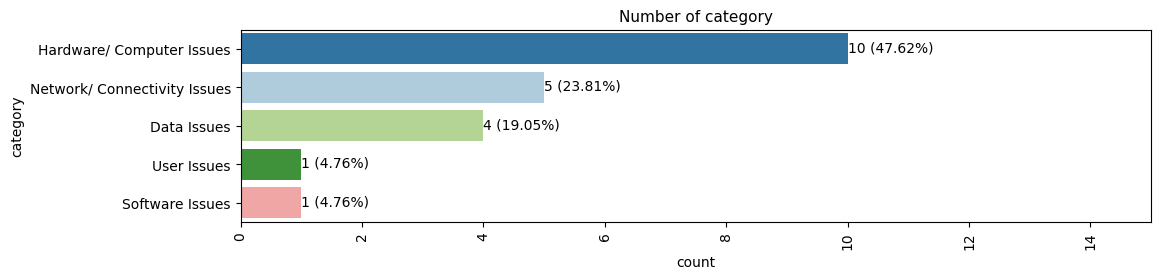

In [ ]:
# Display the number of tickets with regards to category
show_countplot(data = final_data, feature = 'category', figsize = (11.75, 2.5))

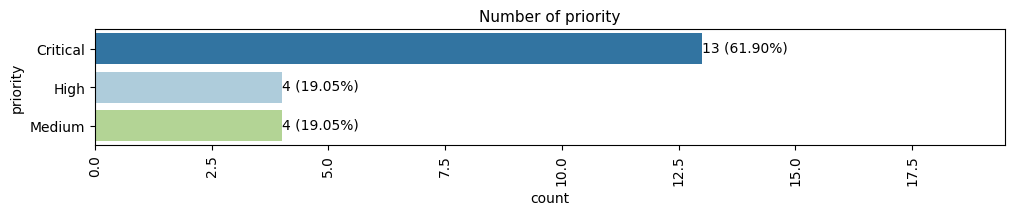

In [ ]:
# Display the number of tickets with regards to priority
show_countplot(data = final_data, feature = 'priority', figsize = (11.75, 1.5))

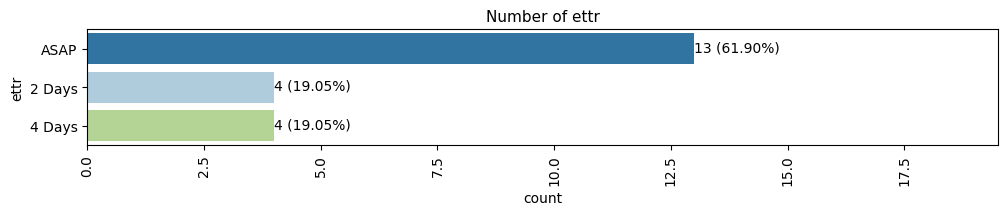

In [ ]:
# Display the number of tickets with regards to ettr
show_countplot(data = final_data, feature = 'ettr', figsize = (11.75, 1.5))

priority,Critical,High,Medium,All
category,,,,
Data Issues,4,0,0,4
Hardware/ Computer Issues,6,2,2,10
Network/ Connectivity Issues,2,1,2,5
Software Issues,0,1,0,1
User Issues,1,0,0,1
All,13,4,4,21


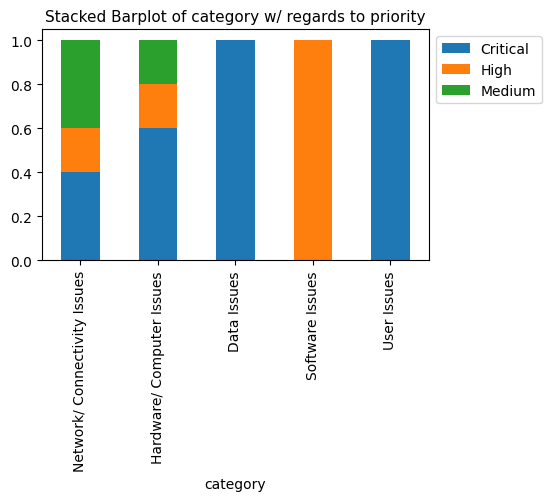

In [ ]:
# Display the distribution of category with regards to priority
show_stackedbarplot(data = final_data, feature = 'category', target = 'priority', figsize = (5, 3))

ettr,2 Days,4 Days,ASAP,All
category,,,,
Data Issues,0,0,4,4
Hardware/ Computer Issues,2,2,6,10
Network/ Connectivity Issues,1,2,2,5
Software Issues,1,0,0,1
User Issues,0,0,1,1
All,4,4,13,21


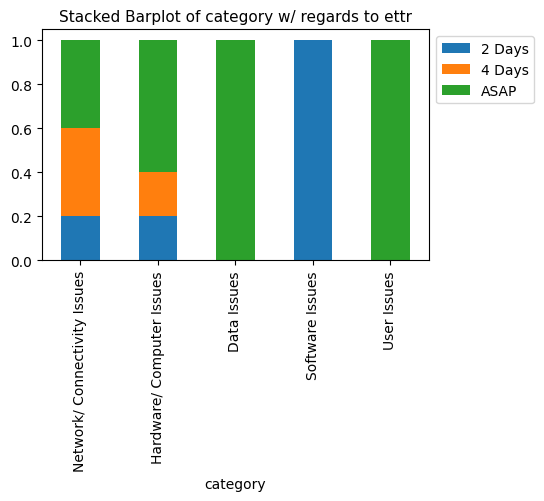

In [ ]:
# Display the distribution of category with regards to ettr
show_stackedbarplot(data = final_data, feature = 'category', target = 'ettr', figsize = (5, 3))

**Observations:**
* Category shows a higher percentage of issues reported by the users are categorized as Hardware/ Computer Issues (with 10 issues or 47.62%). List is followed by:
  * Network/ Connectivity Issues (with 5 issues or 23.81%)
  * Data Issues (with 4 issues or 19.05%)
  * User Issues (with 1 issue or 4.76%)
  * Software Issues (with 1 issue or 4.76%)
* Priority and Estimated Time To Resolution (ETTR) shows a higher percentage of issues reported by the users are prioritized as Critical/ ASAP (with 13 issues or 61.90%). List is followed by:
  * High/ 2 Days - (with 4 issues or 19.05%)
  * Medium/ 4 Days - (with 4 issues or 19.05%)
* Category and Priority shows a higher percentage of issues reported by the users are Hardware/ Computer Issues - Critical (with 6 issues or 28.57%), High (with 2 issues or 9.52%) and Medium (with 2 issues or 9.52%). List is followed by:
  * Network/ Connectivity Issues - Critical (with 2 issues or 9.52%), High (with 2 issues or 9.52%), Medium (with 1 issues or 4.76%)
  * Data Issues - Critical (with 2 issues or 19.05%)
  * User Issues - Critical (with 1 issues or 4.76%)
  * Software Issues - High (with 1 issues or 4.76%)
* Category and Estimated Time To Resolution (ETTR) shows a higher percentage of issues reported by the users are Hardware/ Computer Issues - ASAP (with 6 issues or 28.57%), 2 Days (with 2 issues or 9.52%) and 4 Days (with 2 issues or 9.52%). List is followed by:
  * Network/ Connectivity Issues - ASAP (with 2 issues or 9.52%), 2 Days (with 2 issues or 9.52%), 4 Days (with 1 issues or 4.76%)
  * Data Issues - ASAP (with 2 issues or 19.05%)
  * User Issues - ASAP (with 1 issues or 4.76%)
  * Software Issues - 2 Days (with 1 issues or 4.76%)


## Actionable Insights and Recommendations

### Conclusions:

* As observed during the Model Output Analysis, the majority of the issues reported by the users are categorized as **Hardware/ Computer Issues** (with 10 issues or 47.62%) and **Network/ Connectivity Issues** (with 5 issues or 23.81%). Also, the majority of the issues reported by the users are prioritized as **Critical/ ASAP** (with 13 issues or 61.90%).
* The model **mistral-7b-instruct-v0.2.Q6_K.gguf** was able to correctly classify the categories, tags, priorities, and estimated time to resolution (ETTR) based on the issues provided by the users.
* The model was also able to produce a valid JSON message and generate a draft response to users using a sample response message (as a template).
* The prompt and the model output can be improved once detailed requirements are provided, such as a list of categories, priorities, and the format of the response message to users.
* The overall execution from task 1 to task 4 took around 30 minutes and 10 seconds to process all 21 tickets. This can significantly increase the company's productivity by automating the initial phase of the support ticket lifecycle.

### Recommendations:

* A **list of categories must be provided** to determine the scope of the issues. Without this, the list of categories and tags can become extensive, making the model perform slower due to a longer prompt that it needs to process.
* A **list of priorities (including their requirements) must be provided** to determine the severity that will qualify for which level of priority. This will also determine the resolution time needed to resolve an issue.
* The model **mistral-7b-instruct-v0.2.Q6_K.gguf** must be fine-tuned using data specific to a company (e.g. data containing information that is only known within the company) to improve the model's accuracy. Once the model is used, it can significantly increase the company's productivity in classifying support tickets.


___